In [1]:
import pandas as pd
import numpy as np
import math

import requests
from urllib.parse import urlencode

import pandahouse as ph
import csv
import seaborn as sns
from matplotlib import pyplot as plt
from calendar import monthrange
from pandas.tseries.offsets import MonthBegin
import datetime
from scipy import stats
from scipy.stats import levene

# Задание №1

In [96]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

path_to_file = {
    'data_group':       ['https://disk.yandex.ru/d/E4S5vb5AbgPEOw', ';'],
    'data_group_add':   ['https://disk.yandex.ru/d/-o3TkZ4LepkoDw', ','],
    'data_stud': ['https://disk.yandex.ru/d/jRQlDzZIV04uUw', ','],
    'data_checks':       ['https://disk.yandex.ru/d/Umsq1jP0CL7EaA', ';']
            }
for csv_filename, csv_link in path_to_file.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

In [97]:
data_stud

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [98]:
data_stud.isnull().sum()

student_id    0
dtype: int64

In [99]:
data_stud.student_id.nunique()

8341

In [100]:
data_checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [101]:
data_checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [102]:
data_checks.student_id.nunique()

541

In [103]:
data_group

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [104]:
data_group_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [105]:
data_ab = data_group.append(data_group_add)

In [106]:
data_ab.id.nunique()

74576

Не найдя аномалий в данных, было принято решение перейти к подготовке таблиц для проверки гипотез о стат значимости различий тех или иных метрик.
1. Средний доход на пользователя в группе выше неслучайным образом (ARPU);
2. Конверсия в покупку группы B статистически отлична от группы A.

In [107]:
data_ab

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [108]:
data_checks['flag'] = data_checks.student_id.apply(lambda x: 1 if x in list(data_stud.student_id) else 0)

In [109]:
data_checks.query("flag == 0").count()

student_id    149
rev           149
flag          149
dtype: int64

Было обнаружено, что 149 клиентов не заходили на сайт в день тестирования, а значит такие клиенты не могли стать свидетелями новой системы оплаты. Их не стоит учитывать при оценке эффективности эксперимента

In [110]:
pd.merge(data_checks, data_ab, 
        how='left', 
        left_on= 'student_id',
        right_on = 'id').drop(columns = ['id'])

,student_id,rev,flag,grp
0,1627,990.0,1,A
1,3185,690.0,0,B
2,25973,690.0,0,B
3,26280,690.0,0,B
4,100300,990.0,1,B
...,...,...,...,...
536,5645737,1900.0,1,B
537,5651566,1900.0,1,B
538,5662322,1900.0,1,B
539,5681918,1900.0,1,B


In [111]:
data_checks.query("flag == 1").student_id.nunique()

392

Соединим полученные сущности, где главной будет являться та, которая имеет меньше всего записей (в нашем случае важно, чтобы был известен и ID, и доход, и группа тестирования пользователя). Итоговой сущностью для оценки среднего дохода пользователейрнг будет таблица, содержащая 392 записи.

In [112]:
data = pd.merge(    
        pd.merge(data_checks, data_ab, 
            how='left', 
            left_on= 'student_id',
            right_on = 'id').drop(columns = ['id']),
        data_stud,
        how='left', 
        left_on= 'student_id',
        right_on = 'student_id')

In [113]:
data

,student_id,rev,flag,grp
0,1627,990.0,1,A
1,3185,690.0,0,B
2,25973,690.0,0,B
3,26280,690.0,0,B
4,100300,990.0,1,B
...,...,...,...,...
536,5645737,1900.0,1,B
537,5651566,1900.0,1,B
538,5662322,1900.0,1,B
539,5681918,1900.0,1,B


In [114]:
data.query("grp == 'A' and flag == 1").rev.count()

78

In [115]:
data.query("grp == 'A' and flag == 1").rev.mean()

933.5897435897435

In [116]:
data.query("grp == 'B' and flag == 1").rev.mean()

1257.8789920382164

In [117]:
data.query("grp == 'B' and flag == 1").rev.mean()/data.query("grp == 'A' and flag == 1 ").rev.mean()-1

0.34735733835458515

Для проверки первой гипотезы применим t-тест, но предварительно проверим наши подвыборки на равенство дисперсий.
Выдвигаем нулевую гипотезу о равенстве дисперсий и проверим с помощью критерия Левана

In [118]:
levene(data.query("grp == 'A' and flag == 1").rev, data.query("grp == 'B' and flag == 1").rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Критерий говорит нам о равенстве дисперсий, что в свою очередь говорит нам о повышении вероятности допустить ошибку первого или второго рода. В этом случае передадим параметр "equal_var=False" в t-тест, в котором H0 будет говорить нам о равенстве среднего дохода двух групп, H1 - статистическое различие в средних двух групп есть.

In [119]:
stats.ttest_ind(data.query("grp == 'A' and flag == 1").rev, data.query("grp == 'B' and flag == 1").rev, equal_var=False)

Ttest_indResult(statistic=-2.861689755269415, pvalue=0.005069734012800116)

Отвергаем нулевую гипотезу о равенстве средних, что говорит нам об статистических различиях между тратами двух групп

Подготовим данные для проверки второй гипотезы

In [120]:
data_web = pd.merge(data_stud, data_ab, 
            how='left', 
            left_on= 'student_id',
            right_on = 'id').drop(columns = ['student_id'])

In [121]:
data_web.groupby(['grp'], as_index=False).count()

,grp,id
0,A,1538
1,B,6803


Конверсия захода на сайт

In [122]:
100*data_web.groupby(['grp'], as_index=False).count().id[0]/data_ab.groupby(['grp'], as_index=False).count().id[0]

10.467569590961682

In [123]:
100*data_web.groupby(['grp'], as_index=False).count().id[1]/data_ab.groupby(['grp'], as_index=False).count().id[1]

11.36048628158242

Конверсия из входа на сайт в покупку

In [124]:
100*data.query("grp == 'A' and flag == 1").student_id.count()/data_web.groupby(['grp'], as_index=False).count().id[0]

5.071521456436931

In [125]:
100*data.query("grp == 'B' and flag == 1").student_id.count()/data_web.groupby(['grp'], as_index=False).count().id[1]

4.615610759958842

Конверсия в покупку от числа пользователей, зашедших на сайт

In [126]:
data_ab

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [128]:
data_ab['flag'] = data_ab.id.apply(lambda x: 1 if x in list(data.query('flag == 1').student_id) else 0)

In [129]:
data_ab

,id,grp,flag
0,1489,B,0
1,1627,A,1
2,1768,B,0
3,1783,B,0
4,1794,A,0
...,...,...,...
87,200247820,B,0
88,201032527,B,0
89,201067612,B,0
90,201067653,B,0


Выдвинем нулевую гипотезу о равенстве конверсии в покупку среди всех известных нам пользователей (H0 - стат различий в равенстве средних нет)

In [130]:
stats.ttest_ind(data_ab.query("grp == 'A'").flag, data_ab.query("grp == 'B'").flag, equal_var=False)

Ttest_indResult(statistic=0.09741131291112443, pvalue=0.9224006343621977)

Можно сделать вывод о том, что нулевая гипотеза о равенстве конверсии клиентов из разных групп. 
Также проверим конверсию клиентов из числа тех, кто зашел на платформу в день эксперимента

In [131]:
data_web['flag'] = data_web['id'].apply(lambda x: 1 if x in list(data.query('flag == 1').student_id) else 0)

In [132]:
stats.ttest_ind(data_web.query("grp == 'A'").flag, data_web.query("grp == 'B'").flag, equal_var=False)

Ttest_indResult(statistic=0.7415849887091547, pvalue=0.4584173887363956)

Аналогично, можно сделать вывод о том, что конверсия клиентов изменилась не стат значимо

Подводя итог оценки эффективности проведения эксперимента на платформе, можно сделать вывод о том, что конверсия пользователей не изенилась (ни в худшую, и ни в лучшую сторону), то есть поведение покупателей относительно вопроса : "Покупать или нет?", не изменилась. В то время как у экспериментальной группы стат значимо увеличился средний чек на 34%, что говорит о влиянии эксперимента. По совокупности факторов, необходимо вводить эксперимент на постоянной основе.

# Задание №2.

In [37]:
import pandahouse as ph

In [38]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Использование оператора WITH в данном случае необходимо, если база данных будет расширенна новыми записями, и запрос отберёт только студентов, проходивших тест за последний имеющийся месяц (предполагается, что он и является текущим).

In [39]:
q1 = '''
    WITH (SELECT toStartOfMonth(CAST(MAX(timest) as date)) FROM default.peas) AS last_date
 SELECT 
    COUNT(*) as count_good_student
FROM (
    SELECT 
        st_id,
        SUM(correct) as sum_corr
    FROM default.peas
    WHERE toStartOfMonth(CAST(timest as date)) == last_date
    GROUP BY st_id
    HAVING sum_corr > 19
    ORDER BY sum_corr DESC
    )
    '''

In [40]:
good_student = ph.read_clickhouse(query=q1, connection=connection_default)
good_student

,count_good_student
0,136


In [41]:
q2 = '''
WITH 
    (SELECT COUNT(*) FROM (SELECT DISTINCT st_id FROM peas)
                        ) AS count_all_clients,
    (SELECT SUM(active) FROM (SELECT st_id, if(SUM(correct)>10,1,0) as active FROM peas GROUP BY st_id)
                        ) AS count_active_clients,
    (SELECT SUM(active_math) FROM (SELECT st_id, if(SUM(correct)>1,1,0) as active_math FROM peas WHERE subject == 'Math' GROUP BY st_id)
                        ) AS count_active_math_clients,
    amu as (
    SELECT 
        st_id as st_id,
        active_math as active_math
    FROM (
        SELECT 
            st_id,
            if(SUM(correct)>1,1,0) as active_math
        FROM peas
        WHERE subject == 'Math'
        GROUP BY st_id
        )
    ),
    au as (
    SELECT 
        st_id as st_id,
        active as active
    FROM (
        SELECT 
            st_id,
            if(SUM(correct)>10,1,0) as active
        FROM peas
        GROUP BY st_id
        )
    ),
    all_table as (
    --итоговая таблица со всеми данными необходимыми для расчёта метрик
    SELECT 
        l.st_id as st_id,
        l.sale_time as sale_time,
        l.money as money,
        l.subject as subject,
        l.test_grp as test_grp,
        r.active as active,
        r.active_math as active_math
    FROM (
        -- данные о чеках и группе тестирования
        SELECT
            l.st_id as st_id,
            l.sale_time as sale_time,
            l.money as money,
            l.subject as subject,
            r.test_grp as test_grp
        FROM final_project_check as l
        LEFT JOIN studs as r
        ON l.st_id = r.st_id
            ) as l
    -- подливаем данные по активности клиентов
    LEFT JOIN 
            (
            --данные активности по всем предметам
            SELECT
                l.st_id as st_id,
                l.active as active,
                r.active_math as active_math
            FROM au as l
            LEFT JOIN 
            --данные активности по математике
                amu as r
            ON l.st_id = r.st_id
            ) as r
    ON l.st_id = r.st_id
    ),
-- help table
    ht as (
    select test_grp, st_id
    from all_table
    where active == 1
    group by test_grp, st_id
    ),
    ht2 as (
    select test_grp, count(st_id) as total_active
    from ht
    group by test_grp),
    ht_math as (
    select test_grp, st_id
    from all_table
    where active_math == 1
    group by test_grp, st_id
    ),
    ht_math2 as (
    select test_grp, count(st_id) as total_active_math
    from ht_math
    group by test_grp)
 
 SELECT
    all_table.test_grp,
    round(SUM(money)/count_all_clients,2) as ARPU,
    round(SUM(money*active)/count_active_clients,2) as ARPAU,
    round(100*COUNT(DISTINCT st_id)/count_all_clients, 2) as CR,
    round(100*ht2.total_active/count_active_clients, 2) as CR_active,
    round(100*ht_math2.total_active_math/count_active_math_clients, 2) as CR_active_math
    
 FROM all_table
 left join ht2 on ht2.test_grp = all_table.test_grp
 left join ht_math2 on ht_math2.test_grp = all_table.test_grp
 group by all_table.test_grp, ht_math2.test_grp, ht_math2.total_active_math, ht2.test_grp, ht2.total_active
    '''

In [42]:
metrics = ph.read_clickhouse(query=q2, connection=connection_default)
metrics

,all_table.test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4496.75,5919.28,4.87,6.28,5.49
1,pilot,11022.73,12802.69,10.39,11.21,6.59


# Задание №3.

In [43]:
data_stud = pd.read_csv(path_to_file_student , sep = ',')
data_stud

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [44]:
data_group = pd.read_csv(path_to_file_group , sep = ';')
data_group

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [45]:
data_checks = pd.read_csv(path_to_file_checks , sep = ';')
data_checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


На практике понятнее решать проблемы с подготовкой данных для работы. В данном случае, нет уточнений какие проблемы могут возникнуть, поэтому напишем несколько функций для решения проблемы с разделителем в файле Excel, а также обработка данных на пропущенные значения

In [64]:
def delim(path):
    sniffer = csv.Sniffer()
    with open(path) as fp:
        delimiter = sniffer.sniff(fp.read(5000)).delimiter
    return delimiter
    #определяем разделитель
def processing(path, delimiter):
    data_group_add = pd.read_csv(path , sep = delimiter)
    data_group_add = data_group_add.dropna()
    data_group_add = data_group_add[(data_group_add.grp == 'A') | (data_group_add.grp == 'B')]
    if (str(data_group_add.iloc[0, 0]).isalpha() == False):
        data_group_add.columns = ['id', 'grp']
    else:
        data_group_add.columns = ['grp','id']
    return data_group_add
    #считываем и удаляем пропущенные значения, а также строки, в которых группа не принадлежит A или B
    #переименовываем столбцы, без проверки на наличие других колонок

In [109]:
def a_b_test(df):
    data_group = pd.read_csv(path_to_file_group , sep = ';')
    data_checks = pd.read_csv(path_to_file_checks , sep = ';')
    data_stud = pd.read_csv(path_to_file_student , sep = ',')
    data_ab = data_group.append(df)
    data = pd.merge(    
        pd.merge(data_checks, data_ab, 
            how='left', 
            left_on= 'student_id',
            right_on = 'id').drop(columns = ['id']),
        data_stud,
        how='left', 
        left_on= 'student_id',
        right_on = 'student_id')
    ARPU_a = data.query("grp == 'A'").rev.mean()
    ARPU_b = data.query("grp == 'B'").rev.mean()
    print('Средний доход с пользователя в группе А:', ARPU_a)
    print('Средний доход с пользователя в группе B:', ARPU_b)
    print('Результаты t-теста:', stats.ttest_ind(data.query("grp == 'A'").rev, data.query("grp == 'B'").rev, equal_var=False))
    if (stats.ttest_ind(data.query("grp == 'A'").rev, data.query("grp == 'B'").rev, equal_var=False)[1] < 0.05):
        print('Отвергаем нулевую гипотезу о равенстве средних, статистические различия между тратами двух групп есть')
    else:
        print('Принимаем нулевую гипотезу о равенстве средних, статистических различий между тратами двух групп нет')
    data_web = pd.merge(data_stud, data_ab, 
            how='left', 
            left_on= 'student_id',
            right_on = 'id').drop(columns = ['student_id'])
    data_web['flag'] = data_web['id'].apply(lambda x: 1 if x in list(data.student_id) else 0)
    convertion_a = data_web.query("grp == 'A'").flag.mean()
    convertion_b = data_web.query("grp == 'B'").flag.mean()
    print('Конверсия в покупку пользователей из числа зашедших на сайт в группе А: ', convertion_a)
    print('Конверсия в покупку пользователей из числа зашедших на сайт в группе B: ', convertion_b)
    print('Результаты t-теста:',stats.ttest_ind(data_web.query("grp == 'A'").flag, data_web.query("grp == 'B'").flag, equal_var=False))
    if (stats.ttest_ind(data_web.query("grp == 'A'").flag, data_web.query("grp == 'B'").flag, equal_var=False)[1] < 0.05):
        print('Отвергаем нулевую гипотезу о равенстве средних, статистические различия между конверсией покупателей двух групп есть')
    else:
        print('Принимаем нулевую гипотезу о равенстве средних, статистических различий между конверсией покупателей двух групп нет')
    return data, data_web, ARPU_a, ARPU_b, convertion_a, convertion_b

In [137]:
def bar_plot(data,data_web): 
    plt.figure(figsize=[16, 7])
    plt.suptitle('Метрики и доверительный интервал')
    plt.subplot(1, 2, 1)
    ax_1 = sns.barplot(data = data, x="grp", y="rev")
    ax_1.set_ylabel('Доход с пользователя')
    ax_1.set_xlabel('Группа пользователей')
    plt.subplot(1, 2, 2)
    ax_2 = sns.barplot(data = data_web, x="grp", y="flag")
    ax_2.set_ylabel('Конверсия в покупку')
    ax_2.set_xlabel('Группа пользователей')

In [139]:
data_group_add = processing(path_to_file_group_add, delim(path_to_file_group_add))

In [140]:
data_group_add = processing(path_to_file_group_add, delim(path_to_file_group_add)) #инициализируем и подготавливаем данные
data, data_web, ARPU_a, ARPU_b, convertion_a, convertion_b = a_b_test(data_group_add) #проводим анализ эксперимента

Средний доход с пользователя в группе А: 860.7102803738318
Средний доход с пользователя в группе B: 1108.8248930875575
Результаты t-теста: Ttest_indResult(statistic=-2.8670185482728643, pvalue=0.004731862454849822)
Отвергаем нулевую гипотезу о равенстве средних, статистические различия между тратами двух групп есть
Конверсия в покупку пользователей из числа зашедших на сайт в группе А:  0.05071521456436931
Конверсия в покупку пользователей из числа зашедших на сайт в группе B:  0.046156107599588415
Результаты t-теста: Ttest_indResult(statistic=0.7415849887091547, pvalue=0.4584173887363956)
Принимаем нулевую гипотезу о равенстве средних, статистических различий между конверсией покупателей двух групп нет


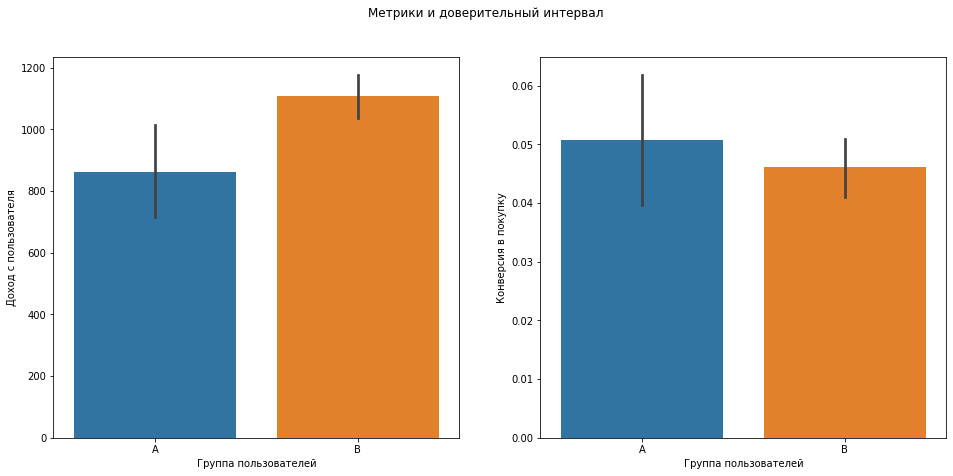

In [141]:
bar_plot(data,data_web)